# Basic Settings

## Modules

In [1]:
import torch
import time
import copy
import os
import glob
import sys
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from data_utils import DatasetUtils
from model_utils import ModelUtils
from result_utils import ResultUtils
from torch.cuda.amp import GradScaler
from torchvision.models import densenet201, inception_v3, resnet50, swin_v2_t
from efficientnet_pytorch import EfficientNet
from collections import Counter
from pycm import *

## Data Set and Files

In [2]:
# Specify the path to your dataset
Target_addr = '/data/NeuroRG/Data/numpy/Neuroinflammation/230331/'
Output_address = '/data/NEURORG_PAPER/rst/'

# Define plate and severe lists
plate_list = ["1", "2", "3", "4", "5"]
plate_list_split = DatasetUtils.get_splited_list(plate_list)
severe_list = ['0uM', '0.005uM', '0.05uM', '0.5uM', '5uM', '20uM']

# Get normalization parameters
mean_list, std_list = DatasetUtils.get_normalize_parameters(Target_addr)

## Model

In [3]:
# Model name
model_name = 'efficientnet_b5'
batch_size = 8

# Initialize the result lists
acc_per_img = []
acc_per_well = []

In [4]:
# GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

scaler = torch.cuda.amp.GradScaler()

def train_model(model, criterion, optimizer, scheduler, plate_idx, dataloaders, dataset_sizes, device, target_addr, model_name, num_epochs=25):
        since = time.time()

        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        PATH = f"{target_addr}/Parameters/state_dict"
        os.makedirs(os.path.dirname(PATH), exist_ok=True)

        for epoch in range(num_epochs):
            #print(f'Epoch {epoch}/{num_epochs - 1}')
            #print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        with torch.cuda.amp.autocast(enabled=phase == 'train'):
                            outputs = model(inputs)
                            if isinstance(outputs, tuple):  # Inception v3
                                outputs = outputs[0]
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)

                        if phase == 'train':
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                #print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        if isinstance(model, nn.DataParallel):
            torch.save(copy.deepcopy(model.module.state_dict()), f'{PATH}_{model_name}_{plate_idx}')
        else:
            torch.save(copy.deepcopy(model.state_dict()), f'{PATH}_{model_name}{plate_idx}')

        return model

# Ensemble Based Analysis

This step would take a long time for training... If you want to skip the training step, please use stored parameters in GitHub repository.

In [5]:
for plate_idx, val_plate_list in enumerate(plate_list_split):
    print(f'Plates(validations): {val_plate_list}')

    # 1. Splitting the Dataset: Train vs. Validation
    train_plate_list = list(set(plate_list) - set(val_plate_list))
    
    # 2. Loading the Dataset and Configuring Data Loader
    train_dataset = DatasetUtils.get_dataset(Target_addr, 'train', train_plate_list, severe_list, mean_list, std_list, model_name)
    val_dataset = DatasetUtils.get_dataset(Target_addr, 'val', val_plate_list, severe_list, mean_list, std_list, model_name)
    
    # 3. Configuring Data Loader
    dataloaders = {
                'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16,
                                    pin_memory=torch.cuda.is_available()),
                'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=16,
                                  pin_memory=torch.cuda.is_available())
    }
    dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
    
    # 4. Initializing and Configuring the Model
    model_ft = ModelUtils.initialize_model(model_name, num_classes=6)
    model_ft = torch.nn.DataParallel(model_ft, device_ids=[0, 1, 2, 3]) # Specify your device ids!!
    model_ft = model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    
    for idx, (n, p) in enumerate(model_ft.named_parameters()):
        p.requires_grad = True
        
    optimizer_ft = ModelUtils.get_optimizer(model_ft, model_name)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.25)
    
    # 5. Training the Model
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, plate_idx, dataloaders, dataset_sizes, device, Output_address, model_name, num_epochs = 20)
    
    # 6. Model Evaluation (with the validation set)
    well_df = DatasetUtils.get_val_csv(Target_addr, 'val', val_plate_list, severe_list)
    dataset_test = DatasetUtils.get_dataset(Target_addr, 'test', val_plate_list, severe_list, mean_list, std_list, model_name)
    dataloaders_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=16,
                                   pin_memory=torch.cuda.is_available())
    dataset_sizes_test = len(dataloaders_test)
    
    model_ft.eval()
    prediction = []
    labels_list = []
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            correct = 0
            total = 0
            for images, labels in dataloaders_test:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model_ft(images)
                _, predicted = torch.max(outputs.data, 1)
                prediction.append(predicted.cpu().numpy())
                labels_list.append(labels.cpu().numpy())
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print('Accuracy of the model on the val images: {} %'.format(100 * correct / total))
            acc_per_img.append(100 * correct / total)

    # 7. Saving the Results
    well_df['prediction'] = np.concatenate(prediction)
    well_df['label'] = np.concatenate(labels_list)
    well_df['model'] = model_name
    well_df['phase'] = 'train'
    well_df['plate_idx'] = plate_idx
    well_df['val_plates'] = '_'.join(val_plate_list)
    well_df.to_csv(f'{Output_address}/Val_predicted_image_{model_name}_val_{plate_idx}.csv')

    result = well_df[['phase', 'model', 'plate_idx', 'val_plates', 'class', 'well', 'prediction', 'label']].groupby(['phase', 'model', 'plate_idx', 'val_plates', 'class', 'well']).apply(ResultUtils.compute_ratios)

    num_of_class = len(severe_list)
    acc_prediction = sum(result['check']) / len(result) * 100

    print(f'Prediction accuracy for Wells: {acc_prediction}')
    acc_per_well.append(acc_prediction)

    result.to_csv(f'{Output_address}/Val_predicted_result_{model_name}_val_{plate_idx}.csv')


Plates(validations): ['1', '5']
train --- Numpy data shape: (2700, 1200, 1200, 3), ---- Numpy data mix shape: (2700,)
Counter({0: 450, 1: 450, 2: 450, 3: 450, 4: 450, 5: 450})
val --- Numpy data shape: (1800, 1200, 1200, 3), ---- Numpy data mix shape: (1800,)
Counter({0: 300, 1: 300, 2: 300, 3: 300, 4: 300, 5: 300})
Loaded pretrained weights for efficientnet-b5
Training complete in 179m 28s
Best val Acc: 0.8211
well_df shape is ---- (1800, 6)
test --- Numpy data shape: (1800, 1200, 1200, 3), ---- Numpy data mix shape: (1800,)
Counter({0: 300, 1: 300, 2: 300, 3: 300, 4: 300, 5: 300})
Accuracy of the model on the val images: 81.11111111111111 %
Prediction accuracy for Wells: 90.83333333333333
Plates(validations): ['2']
train --- Numpy data shape: (3600, 1200, 1200, 3), ---- Numpy data mix shape: (3600,)
Counter({0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 600})
val --- Numpy data shape: (900, 1200, 1200, 3), ---- Numpy data mix shape: (900,)
Counter({0: 150, 1: 150, 2: 150, 3: 150, 4: 150

## Results & Visualization

### Total

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

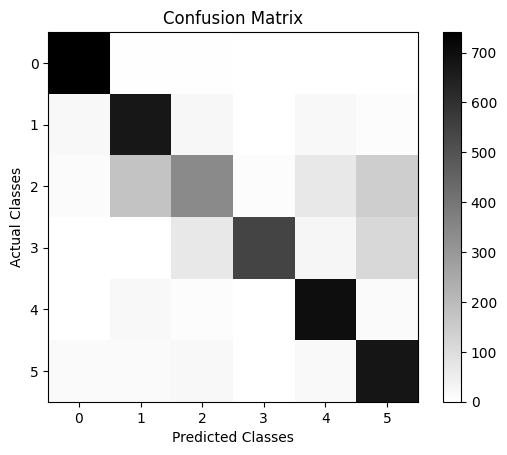

In [6]:
final_df_list = [pd.read_csv(csv) for csv in glob.glob(f'{Output_address}/Val_predicted_image_*.csv')]

final_df = pd.concat(final_df_list, axis=0)

y_actu = final_df['label'].tolist()
y_pred = final_df['prediction'].tolist()

cm = ConfusionMatrix(actual_vector=y_actu, predict_vector=y_pred)
#cm.classes
#print(cm)

cm.plot()

### By fold

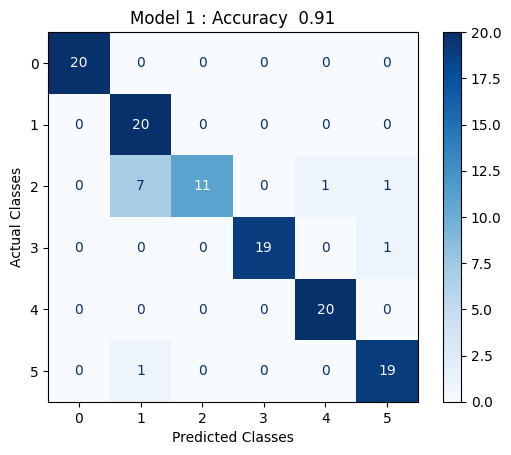

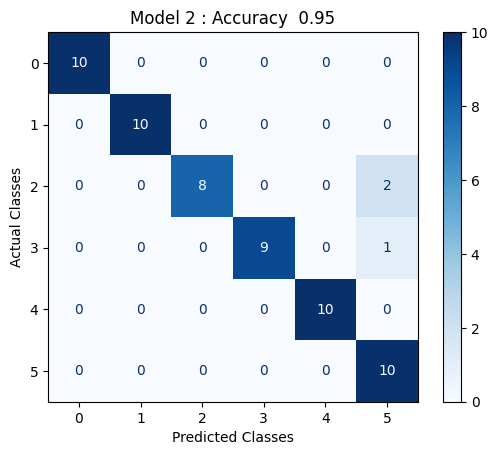

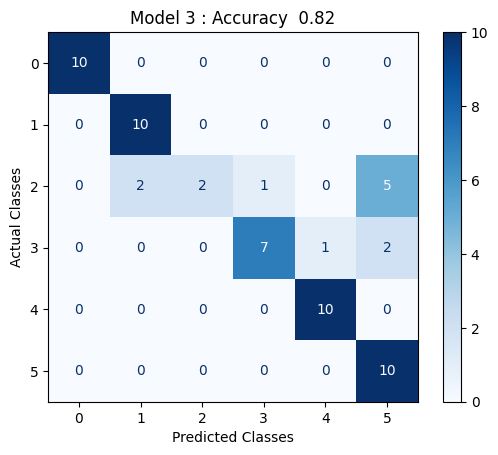

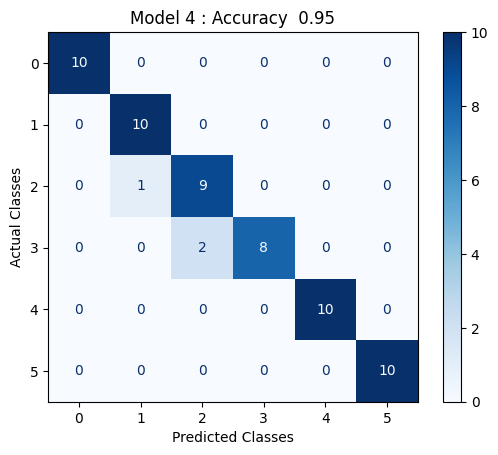

In [9]:
final_df_list = [pd.read_csv(csv) for csv in sorted(glob.glob(f'{Output_address}/Val_predicted_image_*.csv'))]

for df_idx, final_df in enumerate(final_df_list):
    pred_list = []
    actu_list = []
    for well in list(set(final_df.loc[:,"well"])):

        well_subset_df = final_df.query(f'well == "{well}"')

        y_pred = Counter(well_subset_df['prediction'].tolist()).most_common(1)[0][0]
        y_actu = well_subset_df['label'].tolist()[0]

        pred_list.append(y_pred)
        actu_list.append(y_actu)
        
    cm = ConfusionMatrix(actual_vector=actu_list, predict_vector=pred_list)        
    cm.plot(cmap=plt.cm.Blues, number_label=True, plot_lib="matplotlib")
    plt.title(f'Model {df_idx + 1} : Accuracy {cm.overall_stat["Overall ACC"] : .2f}')

In [8]:
cm.overall_stat

{'Overall ACC': 0.95,
 'Overall RACCU': 0.16708333333333336,
 'Overall RACC': 0.16666666666666669,
 'Kappa': 0.94,
 'Gwet AC1': 0.9400059994000599,
 'Bennett S': 0.94,
 'Kappa Standard Error': 0.033763886032268285,
 'Kappa Unbiased': 0.9399699849924962,
 'Scott PI': 0.9399699849924962,
 'Kappa No Prevalence': 0.8999999999999999,
 'Kappa 95% CI': (0.8738227833767541, 1.0061772166232459),
 'Standard Error': 0.0281365716935569,
 '95% CI': (0.8948523194806284, 1.0051476805193715),
 'Chi-Squared': 269.45454545454544,
 'Phi-Squared': 4.49090909090909,
 'Cramer V': 0.9477245476307017,
 'Response Entropy': 2.5774682879978283,
 'Reference Entropy': 2.584962500721156,
 'Cross Entropy': 2.5927826752857386,
 'Joint Entropy': 2.78344978213393,
 'Conditional Entropy': 0.1984872814127739,
 'Mutual Information': 2.3789810065850543,
 'KL Divergence': 0.007820174564582068,
 'Lambda B': 0.9387755102040817,
 'Lambda A': 0.94,
 'Chi-Squared DF': 25,
 'Overall J': (5.459090909090909, 0.9098484848484848),
 '